<a href="https://colab.research.google.com/github/naomifridman/DeepLearning_timeseries_introduction/blob/main/RNN_under_the_hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
#from IPython.display import Image
from IPython.core.display import HTML 



import scipy.io as sio
import os
import time

from IPython.display import display, Markdown, Latex
import warnings
#warnings.filterwarnings('ignore')
import cv2
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = [18, 5]
pd.options.display.max_columns = 100

# Introduction to RNN

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_fig1.png)

# Unfolded representation
![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_fig2.png)

# The Mathematics behind recurent network


![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_form1.png)

We can base predictions on top of ht by using just another matrix projection on top of the hidden state. This is the simplest complete case in which you can wire up a neural network:

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_form2.png)

## Simple RNN handson examples
Original code(Karpathy) : https://gist.github.com/karpathy/d4dee566867f8291f086


![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_1to1.png)

# Data Initialization

In [ ]:
data = "lili i love you i love you i love you a lot you are betiful and smart and i love you lili you are my love"

In [ ]:
data = open('data/love_me_do.txt', 'r').read() # should be simple plain text file
data = data.lower()

In [ ]:

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)

print ('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 2351 characters, 30 unique.


# Recurrent Network Initialization

In [ ]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

print('Sequence length (input size): ', data_size)
print('Number of Hidden units: ', hidden_size)
print('Weights: ', ' weight input -> hidden:', Wxh.shape)
print('Weights: ', ' weight hidden -> hidden:', Whh.shape)
print('Weights: ', '  weight hidden -> output:', Why.shape)

Sequence length (input size):  2351
Number of Hidden units:  100
Weights:   weight input -> hidden: (100, 30)
Weights:   weight hidden -> hidden: (100, 100)
Weights:    weight hidden -> output: (30, 100)


In [ ]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
    
  # forward pass
  for t in range(len(inputs)):
    # encode in 1-of-k representation - one hot
    xs[t] = np.zeros((vocab_size,1)) 
    xs[t][inputs[t]] = 1
    
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

## Training Loop

In [ ]:
n, p = 0, 0
iteration = 20000
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0

for i in range(iteration):
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0: 
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]


    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 500 == 0: print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress
  
    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter 

iter 0, loss: 85.029938
iter 500, loss: 81.191882
iter 1000, loss: 72.710099
iter 1500, loss: 63.953972
iter 2000, loss: 56.383530
iter 2500, loss: 50.211083
iter 3000, loss: 44.907717
iter 3500, loss: 40.706412
iter 4000, loss: 37.434788
iter 4500, loss: 34.471588
iter 5000, loss: 31.975719
iter 5500, loss: 29.756248
iter 6000, loss: 27.784038
iter 6500, loss: 26.035175
iter 7000, loss: 24.364241
iter 7500, loss: 22.856735
iter 8000, loss: 21.554709
iter 8500, loss: 20.411765
iter 9000, loss: 18.991944
iter 9500, loss: 17.980256
iter 10000, loss: 17.284811
iter 10500, loss: 16.198923
iter 11000, loss: 15.283013
iter 11500, loss: 14.488768
iter 12000, loss: 13.986315
iter 12500, loss: 13.411288
iter 13000, loss: 12.491181
iter 13500, loss: 12.079631
iter 14000, loss: 11.668087
iter 14500, loss: 10.957403
iter 15000, loss: 10.316543
iter 15500, loss: 10.463945
iter 16000, loss: 9.887961
iter 16500, loss: 9.187784
iter 17000, loss: 8.659276
iter 17500, loss: 9.034190
iter 18000, loss: 8.

In [ ]:
def predict(test_char, length):
    x = np.zeros((vocab_size, 1)) 
    x[char_to_ix[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh) 
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(vocab_size), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((vocab_size, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = ''.join(ix_to_char[i] for i in ixes)
    print (test_char, txt)

In [ ]:
predict('a',300) # (char, len of output)

a nth i love you
and ind the an, thays teve mebate, onow i love you
any, any, i love me


bowhas ielchy, nod widy nebans onoru.
wheli lla la la oa
love meryk la la)
it's not to love
souple me y, me what they say youf uf onow wod waby, "f ilono that i me shay, tone do

love, lone samer he love me do
wh


In [ ]:
predict('\"',300) # (char, len of output)

" lover
whnt thea.. gon)a loany, haple
don tell me things lit'm gonnd bew can't honleve do
y haptes allash, it wherey newa
ton't walyou that in bove me do
yohon wasy, sonow
at in's and tn true
anking ohou hom ty, me yousever iski'll nea they,.. nobeverme.
"s at youe
aheathe me love you tell me me do
y


# Numerical example 
## Predicting the next point in Sin  - Numpy RNN example
### Create input signal

F 300.0 T 0.04 Fs 5000 Ts 0.0002 N 200


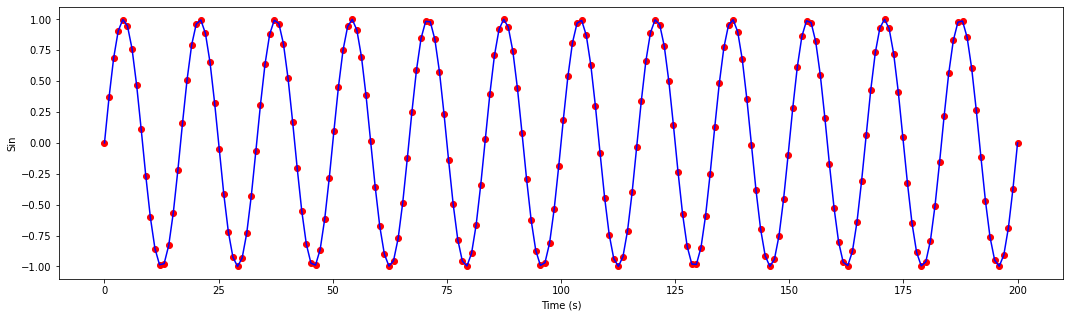

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

F = 300.          # No. of cycles per second, F = 300 Hz
T = 40.e-3        # Time period, T = 40 ms
Fs = 5000         # No. of samples per second, Fs = 50 kHz
Ts = 1./Fs        # Sampling interval, Ts = 20 us
N = int(T/Ts)     # No. of samples for 2 ms, N = 200

print('F', F, 'T', T, 'Fs', Fs, 'Ts', Ts, 'N',N)
# T time peried in miliseconds
# N number of samples (in T time interval)
# t time points, 
# signal - is the values of the sin in the time points
t = np.linspace(0, T, N)
signal = np.sin(2*np.pi*F*t)

plt.plot(t*N/T, signal, color='b')
plt.scatter(t*N/T, signal, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Sin')
plt.show()

We want to use embedding as in previous example, so lets convert the signal to an integer positive series

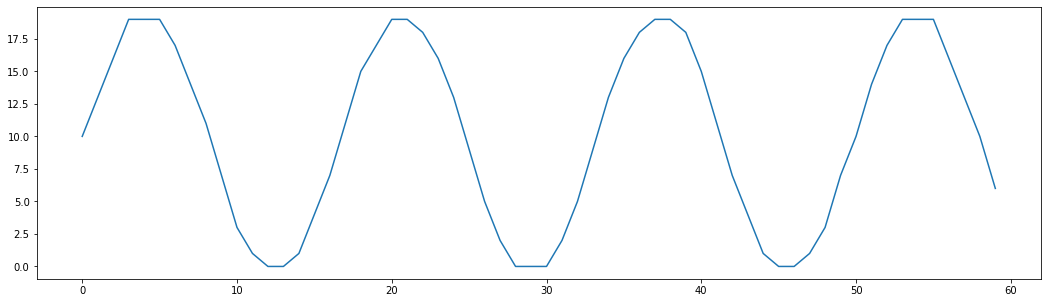

In [ ]:
x = ((signal+1)*10).astype(int)
plt.plot(x[0:60])

# Initialization

In [ ]:
char_to_int = dict((c, i) for i, c in enumerate(np.unique(x))) 
# "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(np.unique(x)))

In [ ]:
# split and remove duplicate characters. convert to list.
chars = list(set(x)) 

# the number of unique characters
num_chars = len(chars) 
txt_data_size = len(x)
chars, num_chars, txt_data_size

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 20,
 200)

In [ ]:
batch_size = 20
x = x[:2000]

In [ ]:
# hyperparameters
txt_data_size = len(x)
print('txt data size: ', txt_data_size)
sequence_length = 10
print('sequence length: ', sequence_length)
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
print('batch_size: ', batch_size)

learning_rate = 1e-1


# model parameters
hidden_size = 100  # size of hidden layer of neurons.  

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

print('Sequence length (input size): ', sequence_length)
print('Number of Hidden units: ', hidden_size)
print('Weights: ', ' weight input -> hidden:', W_xh.shape)
print('Weights: ', ' weight hidden -> hidden:', W_hh.shape)
print('Weights: ', '  weight hidden -> output:', W_hh.shape)
b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

txt data size:  200
sequence length:  10
batch_size:  20
Sequence length (input size):  10
Number of Hidden units:  100
Weights:   weight input -> hidden: (100, 20)
Weights:   weight hidden -> hidden: (100, 100)
Weights:    weight hidden -> output: (100, 100)


# Forward propagation

In [ ]:
def forwardprop(inputs, targets, h_prev):
        
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    
    # Copy previous hidden state vector to -1 key value.
    hs[-1] = np.copy(h_prev) 
    loss = 0 # loss initialization
    
    # t is a "time step" and is used as a key(dic). 
    for t in range(len(inputs)):  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1

        
        # hidden state.
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) 
        
        # unnormalized log probabilities for next chars
        ys[t] = np.dot(W_hy, hs[t]) + b_y 
        
        # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, 
        # but all of the elements are positive through the exp() function.
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) 
        
        # softmax (cross-entropy loss). Efficient and simple code
        loss += -np.log(ps[t][targets[t],0]) 

    return loss, ps, hs, xs 

# Backward propagation

In [ ]:
def backprop(ps, inputs, hs, xs):
    # make all zero matrices.
    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) 
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        # backprop into y. After taking the soft max in the input vector, 
        # subtract 1 from the value of the element corresponding to the correct label.
        dy[targets[t]] -= 1 
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

# Training

In [ ]:
data_pointer = 0
iteration = 900


# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 


for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size-1):
        
        inputs = [char_to_int[ch] for ch in x[data_pointer:data_pointer+sequence_length]]
        
        inputs=np.array(inputs)
        
        targets = [char_to_int[ch] for ch in x[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
        
        targets=np.array(targets)

        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer

    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress



iter 0, loss: 40.924407
iter 100, loss: 1.366237
iter 200, loss: 0.946201
iter 300, loss: 0.861254
iter 400, loss: 0.824316
iter 500, loss: 0.802625
iter 600, loss: 0.788616
iter 700, loss: 0.778957
iter 800, loss: 0.771756


In [ ]:
loss

0.7661309855511046

# Prediction

In [ ]:
def predict(test_char, length):
    xn = np.zeros((num_chars, 1)) 
    xn[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, xn) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        
        ix=np.argmax(p)
        #ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
        xn = np.zeros((num_chars, 1)) 
        test_char_ix = ix
        xn[ix] = 1
    pred = [int_to_char[i] for i in ixes]
    
    return pred

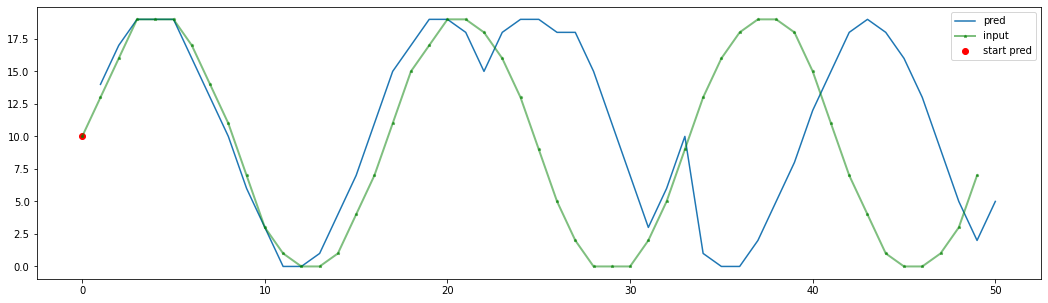

In [ ]:
pred = predict(x[0],50)
plt.plot(np.arange(1, len(pred)+1),pred, label='pred')
plt.scatter([0],[char_to_int[x[0]]], color='r', label='start pred')
plt.plot([char_to_int[c] for c in x[0:50]], marker='*', color='g', 
         lw=2, markersize=3, label='input', alpha=0.5)
plt.legend()

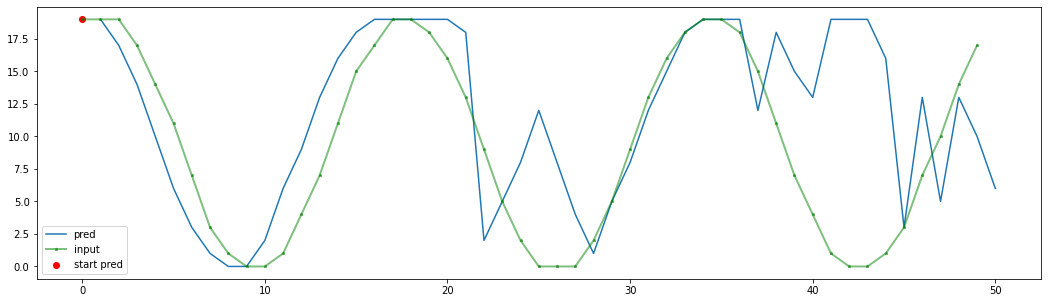

In [ ]:
pred = predict(x[3],50)
plt.plot(np.arange(1, len(pred)+1),pred, label='pred')
plt.scatter([0],[char_to_int[x[3]]], color='r', label='start pred')
plt.plot([char_to_int[c] for c in x[3:53]], marker='*', color='g', 
         lw=2, markersize=3, label='input', alpha=0.5)
plt.legend()

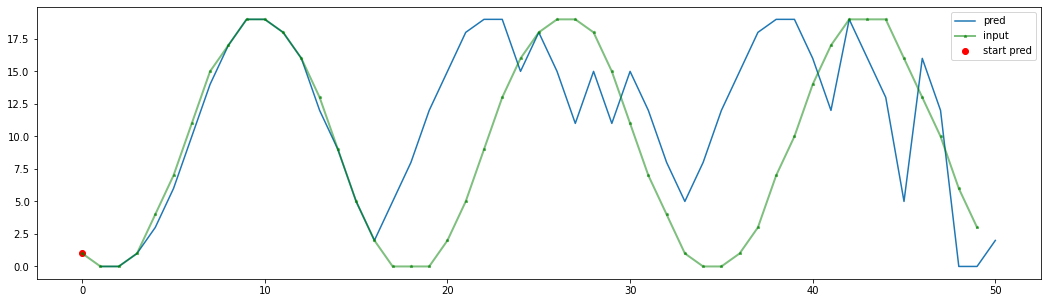

In [ ]:
pred = predict(x[11],50)
#print(pred)
plt.plot(np.arange(1, len(pred)+1),pred, label='pred')
plt.scatter([0],[char_to_int[x[11]]], color='r', label='start pred')
plt.plot([char_to_int[c] for c in x[11:61]], marker='*', color='g', 
         lw=2, markersize=3, label='input', alpha=0.5)
#plt.plot(range(10,30), x[10:30], marker='*', color='gray', lw=2, markersize=20)
plt.legend()

# RNN different architectures for different tasks

![title](one_to_many.png)

# Lets play with Simple RNN
## Many to one

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_mto1.png)

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, Lambda
#adam = optimizers.Adam(lr)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, RNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D, BatchNormalization
from keras.models import Model
from tensorflow.keras import optimizers

### Create Input Signal

F 300.0 T 0.04 Fs 5000 Ts 0.0002 N 200


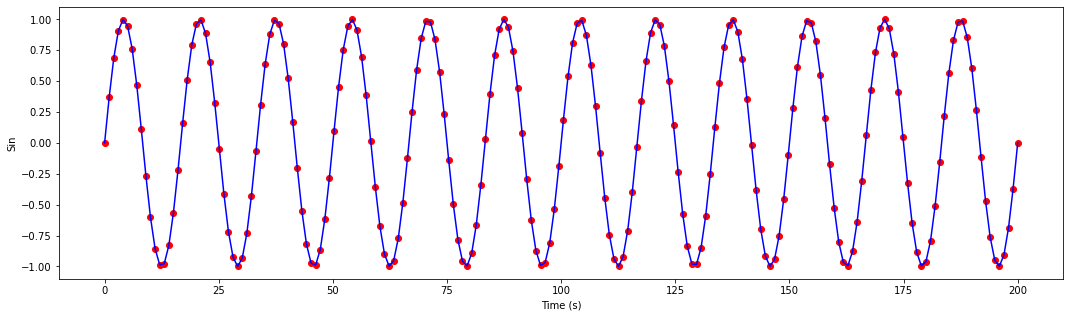

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

F = 300.          # No. of cycles per second, F = 300 Hz
T = 40.e-3        # Time period, T = 40 ms
Fs = 5000         # No. of samples per second, Fs = 50 kHz
Ts = 1./Fs        # Sampling interval, Ts = 20 us
N = int(T/Ts)     # No. of samples for 2 ms, N = 200

print('F', F, 'T', T, 'Fs', Fs, 'Ts', Ts, 'N',N)
# T time peried in miliseconds
# N number of samples (in T time interval)
# t time points, 
# signal - is the values of the sin in the time points
t = np.linspace(0, T, N)
signal = np.sin(2*np.pi*F*t)

plt.plot(t*N/T, signal, color='b')
plt.scatter(t*N/T, signal, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Sin')
plt.show()

In [ ]:
# normalize signal and concatenate for length
x = signal+1

x = np.concatenate([x[:-1] for i in range(50)])/2.
x.shape

(9950,)

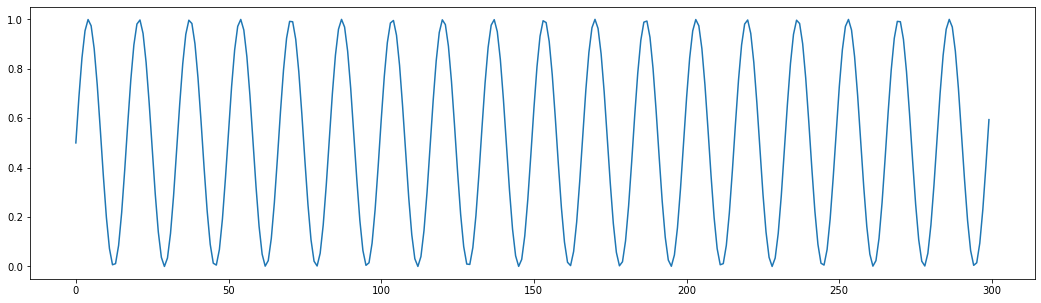

In [ ]:
plt.plot(x[:300])

In [ ]:
input_signal = x.copy()

### Create model train data using keras timeseries_dataset_from_array

In [ ]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


(10, 120) (10,)


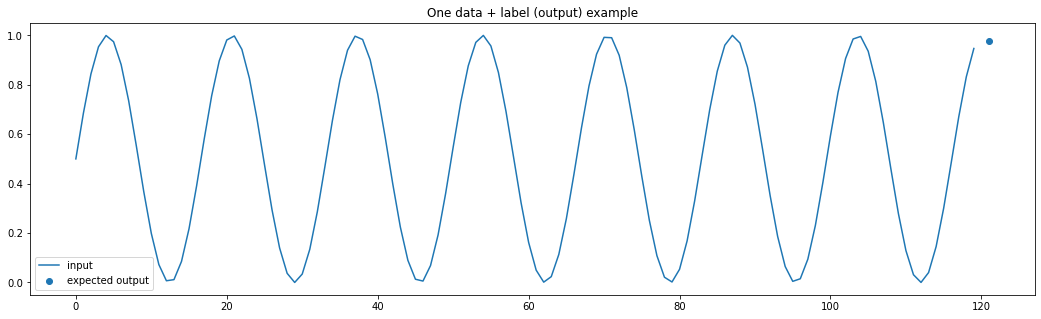

In [ ]:
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x[:1200], 
    targets=x[121:1200+121], 
    sequence_length=120,
    batch_size=10)

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x[1200:2400], 
    targets=x[121+1200:2400+121], 
    sequence_length=120,
    batch_size=10)

for batch in train_dataset:
    inputs, targets = batch
    print(inputs.shape, targets.shape)
    plt.plot(inputs[0], label='input')
    plt.scatter(x=121,y=targets[0], label='expected output')
    plt.title('One data + label (output) example')
    plt.legend()
    break

In [ ]:
num_features = 1
steps = 120
inputs = Input(shape=(steps, num_features))
l = SimpleRNN(20, return_sequences=False)(inputs)

outputs = Dense(1, activation='relu')(l)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 1)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20)                440       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


## Train

In [ ]:

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)

Epoch 1/2
109/109 [==============================] - 4s 24ms/step - loss: 0.0849 - mae: 0.1945 - val_loss: 0.0108 - val_mae: 0.0844
Epoch 2/2
109/109 [==============================] - 2s 21ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 8.3076e-04 - val_mae: 0.0211


## Predict

In [ ]:
tst = input_signal[1200:1200+120].reshape(1,120,1)
pred = model.predict(tst)
pred

array([[0.03340214]], dtype=float32)

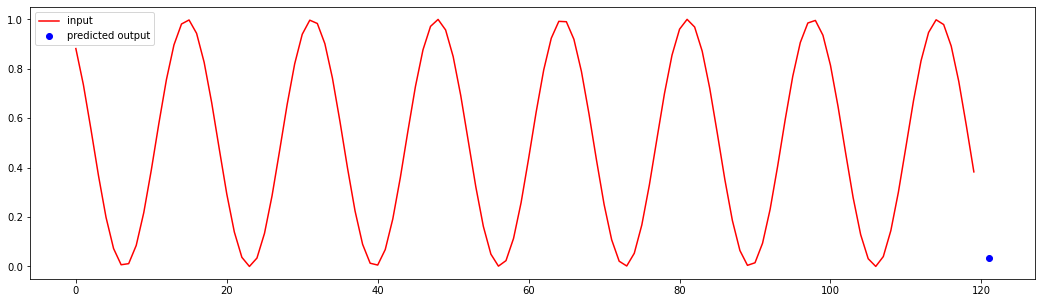

In [ ]:
plt.plot(np.squeeze(tst), color='r', label='input');
plt.scatter(x=121,y=pred[0], label='predicted output', color='b');
plt.legend()

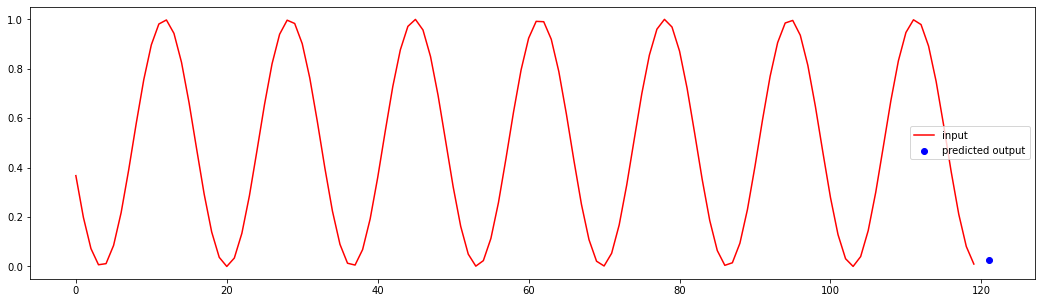

In [ ]:
tst = input_signal[1800:1800+120].reshape(1,120,1)
pred = model.predict(tst)
plt.plot(np.squeeze(tst), color='r', label='input');
plt.scatter(x=121,y=pred[0], label='predicted output', color='b');
plt.legend()

# RNN The Problem of Long-Term Dependencies
### And the problem of vanishing gradient
* from: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_long.png)

# LSTM
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/lstm1.png)

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.
![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/lstm2.png)

LSTMs use a gating mechanism that controls the memoizing process. Information in LSTMs can be stored, written, or read via gates that open and close.
* from https://www.pluralsight.com/guides/introduction-to-lstm-units-in-rnn

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/lstm_gates.png)

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/lstm_gates1.png)
The forget gate decides which information needs attention and which can be ignored. The information from the current input X(t) and hidden state h(t-1) are passed through the sigmoid function. Sigmoid generates values between 0 and 1. It concludes whether the part of the old output is necessary (by giving the output closer to 1). This value of f(t) will later be used by the cell for point-by-point multiplication.

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/lstm_gates2.png)
The input gate performs the following operations to update the cell status.

First, the current state X(t) and previously hidden state h(t-1) are passed into the second sigmoid function. The values are transformed between 0 (important) and 1 (not-important).

Next, the same information of the hidden state and current state will be passed through the tanh function. To regulate the network, the tanh operator will create a vector (C~(t) ) with all the possible values between -1 and 1. The output values generated form the activation functions are ready for point-by-point multiplication.

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/lstm_gates3.png)
The network has enough information form the forget gate and input gate. The next step is to decide and store the information from the new state in the cell state. The previous cell state C(t-1) gets multiplied with forget vector f(t). If the outcome is 0, then values will get dropped in the cell state. Next, the network takes the output value of the input vector i(t) and performs point-by-point addition, which updates the cell state giving the network a new cell state C(t).